In [1]:
# for plotting to visualize some data
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# I have not written a python packaging script, load the NN class within the repository
import sys
from __future__ import print_function
sys.path.append('../')

In [3]:
import HapCNN.utils as utils
import HapCNN.hcnn as hcnn

Shell script example to get testing data from BAM files and (stripped) VCF files
These scripts depend on `falcon_kit.FastaReader` for reading fasta files and `samtools` for parsing alignment records. 

```
mkdir -p ./wd
cd ./wd
python ../helper_scripts/get_SNP_candidates.py --bam_file_fn ../testing_data/chr22/hg38.NA12878-WashU_chr22-18924717-49973797.bam \
                                               --ref_fasta_fn ../testing_data/chr22/chr22.fa \
                                               --pm_count_fn pm_counts_chr22 --ctg_nam chr22
python ../helper_scripts/get_alignment_tensor.py --bam_file_fn ../testing_data/chr22/hg38.NA12878-WashU_chr22-18924717-49973797.bam \
                                                 --pm_count_fn pm_counts_chr22 \
                                                 --ref_fasta_fn ../testing_data/chr22/chr22.fa \
                                                 --ctg_name chr22 > aln_tensor_chr22
```



## Training using Chr21 variant calls

In [5]:
# load the generate alignment "tensors" 
# we don't use the variats outside the regions defined in `CHROM21_v.3.3.2_highconf_noinconsistent.bed`

Xarray, Yarray, pos_array = \
utils.get_training_array("../wd/aln_tensor_chr21", 
                         "../wd/variants_chr21", 
                         "../testing_data/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed" )

In [6]:
print(Xarray.shape)
print(Yarray.shape)

(53537, 15, 4, 3)
(53537, 8)


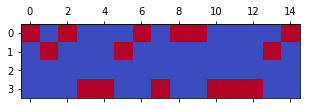

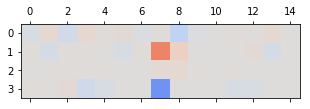

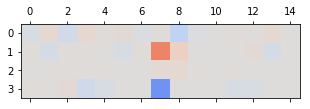

In [7]:
# here we show how the three matrices are like for a candidate site

i = 999
figure(figsize=(5, 2))
matshow(Xarray[i,:,:,0].transpose(), vmin=0, vmax=50, cmap=cm.coolwarm, fignum=0)
figure(figsize=(5, 2))
matshow(Xarray[i,:,:,1].transpose(), vmin=-50, vmax=50, cmap=cm.coolwarm, fignum=0)
figure(figsize=(5, 2))
matshow(Xarray[i,:,:,2].transpose(), vmin=-50, vmax=50, cmap=cm.coolwarm, fignum=0)

In [8]:
%%bash
mkdir -p ../wd/parameters

In [9]:
# create a VariantNet
cnn = hcnn.HAP_CNN()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [10]:
# initialize the parameters
cnn.init()

In [11]:
# training and save the parameters, we train on the first 30000 SNP sites and validate on other 10000 SNP sites
batch_size = 500
validation_lost = []
for i in range(2401):
    Xbatch, Ybatch = utils.get_batch(Xarray[:30000], Yarray[:30000], size=batch_size)
    loss = cnn.train(Xbatch, Ybatch)
    if i % (len(Xarray[:30000])/batch_size) == 0:
        v_lost = cnn.get_loss( Xarray[30000:40000], Yarray[30000:40000] )
        print(i, "train lost:", loss/batch_size, "validation lost", v_lost/10000)
        cnn.save_parameters('../wd/parameters/vn.params-%04d' % i)
        validation_lost.append( (v_lost, i) )
        

0 train lost: 3.72539306640625 validation lost 2.8897869140625
60 train lost: 0.8873594970703125 validation lost 0.92711123046875
120 train lost: 0.6507681884765625 validation lost 0.697503271484375
180 train lost: 0.549986328125 validation lost 0.58614619140625
240 train lost: 0.400969482421875 validation lost 0.501640966796875
300 train lost: 0.38352987670898436 validation lost 0.447988525390625
360 train lost: 0.3977647399902344 validation lost 0.3904426513671875
420 train lost: 0.3853101806640625 validation lost 0.3850858154296875
480 train lost: 0.30514312744140626 validation lost 0.3599074462890625
540 train lost: 0.3052677612304687 validation lost 0.3359606201171875
600 train lost: 0.299947021484375 validation lost 0.3302803955078125
660 train lost: 0.30207510375976565 validation lost 0.316009033203125
720 train lost: 0.2679033203125 validation lost 0.3506486328125
780 train lost: 0.23057183837890624 validation lost 0.3141190185546875
840 train lost: 0.268615234375 validation lo

In [12]:
# pick the parameter set of the smallest validation loss

validation_lost.sort()
i = validation_lost[0][1]
print(i)
cnn.restore_parameters('../wd/parameters/vn.params-%04d' % i)

1560
INFO:tensorflow:Restoring parameters from ../wd/parameters/vn.params-1560


## Testing using Chr22 variant calls

In [13]:
Xarray2, Yarray2, pos_array2 = \
utils.get_training_array("../wd/aln_tensor_chr22", 
                         "../wd/variants_chr22", 
                         "../testing_data/chr22/CHROM22_v.3.3.2_highconf_noinconsistent.bed" )

In [14]:
base, t = cnn.predict(Xarray2)

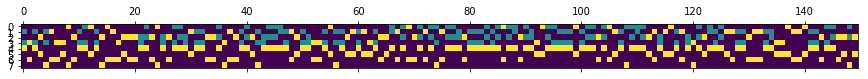

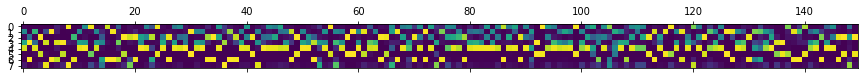

In [15]:
# we can compare the output of the expected calls and the predicted calls

figure(figsize=(15, 5))
matshow(Yarray2[4000:4150,:].transpose(), fignum=0)
figure(figsize=(15, 5))
matshow(np.concatenate( (base[4000:4150,:],t[4000:4150,:]),1).transpose(), fignum=0)


## Quick Evaluation

In [16]:
evaluation_data = []
for pos, predict_v, annotate_v in zip(np.array(pos_array2), t, Yarray2[:,4:]):
    evaluation_data.append( (pos, np.argmax(predict_v), np.argmax(annotate_v)) )
evaluation_data = np.array(evaluation_data)

In [17]:
from collections import Counter

In [18]:
for i in range(4):
    cnt = Counter(evaluation_data[evaluation_data[:,2]==i,1])
    print(i,"\t",)
    for j in range(4):
        print(cnt.get(j,0),"\t",)
    print

0 	
20958 	
283 	
287 	
281 	
1 	
35 	
9607 	
4 	
45 	
2 	
294 	
8 	
11846 	
461 	
3 	
667 	
363 	
247 	
1848 	


In [19]:
ed = evaluation_data
print("Recall rate for het-call (regardless called variant types):", 1.0*sum((ed[:,1]!=2) & (ed[:,2]==0))/sum(ed[:,2]==0))
print("Recall rate for het-call (called variant type = het):", 1.0*sum((ed[:,1]==0) & (ed[:,2]==0))/sum(ed[:,2]==0))
print
print("PPV for het-call (regardless called variant types):", 1.0*sum((ed[:,1]==0) & (ed[:,2]!=2))/sum(ed[:,1]==0))
print("PPV for het-call (called variant type = het):", 1.0*sum((ed[:,1]==0) & (ed[:,2]==0))/sum(ed[:,1]==0))
print
print("Recall rate for hom-call (regardless called variant types):", 1.0*sum((ed[:,1]!=2) & (ed[:,2]==1))/sum(ed[:,2]==1))
print("Recall rate for hom-call (called variant type = hom):", 1.0*sum((ed[:,1]==1) & (ed[:,2]==1))/sum(ed[:,2]==1))
print
print("PPV for hom-call (regardless called variant types):", 1.0*sum((ed[:,1]==1) & (ed[:,2]!=2))/sum(ed[:,1]==1))
print("PPV for hom-call (called variant type = hom):", 1.0*sum((ed[:,1]==1) & (ed[:,2]==1))/sum(ed[:,1]==1))
print
print("Recall rate for all calls:", 1.0*sum((ed[:,1]!=2) & (ed[:,2]!=2))/sum(ed[:,2]!=2))
print("PPV for all calls:", 1.0*sum((ed[:,1]!=2) & (ed[:,2]!=2))/sum(ed[:,1]!=2))

Recall rate for het-call (regardless called variant types): 0.986840295290935
Recall rate for het-call (called variant type = het): 0.960979412169288
PPV for het-call (regardless called variant types): 0.9866083629406942
PPV for het-call (called variant type = het): 0.9546324132276578
Recall rate for hom-call (regardless called variant types): 0.9995872458982561
Recall rate for hom-call (called variant type = hom): 0.9913321638633784
PPV for hom-call (regardless called variant types): 0.99922034889387
PPV for hom-call (called variant type = hom): 0.936263522073872
Recall rate for all calls: 0.9844620938628159
PPV for all calls: 0.9781061692969871


We acutally call more variants outside those "high confidence" (a short alignment concept) regions, e.g., CYP2D6 regions in chr22.

In [20]:
Xarray3, pos_array3 = utils.get_aln_array("../wd/aln_tensor_chr22")
print(Xarray3.shape)

(82618, 15, 4, 3)


In [21]:
all_t = []
for i in range(0,len(Xarray3),10000):
    base, t = cnn.predict(Xarray3[i:i+10000])
    all_t.append(t)
all_t = np.concatenate(all_t)


In [22]:
evaluation_data2 = []
for pos, predict_v in zip(np.array(pos_array3), all_t):
    evaluation_data2.append( (pos, np.argmax(predict_v)) )
evaluation_data2 = np.array(evaluation_data2)
print("Total number of variant from the high-confident short-read call-set: ", sum(ed[:,1]!=2))
print("Total number of variant calls from our chr22 data: ", sum(evaluation_data2[:,1] != 2))

Total number of variant from the high-confident short-read call-set:  34850
Total number of variant calls from our chr22 data:  52817
